# Time series for Orbital Period, Orbital Eccentricity, and Resultant Strain

Simona Miller, LIGO SURF Summer 2018 
(Last updated: July 3, 2018)

In this notebook, I numerically solve the coupled lowest order ordinary differential equations for period decay and eccentricity decay of BBH:

$$
\dot{P}_{orb} = 
-\frac{192\pi}{5c^5} 
\bigg(\frac{2 \pi G} {P_{orb}}\bigg)^{5/3} 
\frac{m_1 m_2}{(m_1 + m_2)^{1/3}}
\bigg(1 + \frac{73}{24}e^2 + \frac{37}{96}e^4\bigg) 
\bigg(1-e^2\bigg)^{-7/2}
$$ 

$$
\dot{e} = 
-\frac{608\pi}{15c^5}
\frac{e}{P_{orb}}
\frac{m_1 m_2}{(m_1 + m_2)^{1/3}}
\bigg(1 + \frac{121}{304}e^2 \bigg) 
\bigg(1-e^2\bigg)^{-5/2}
$$

(Equations are eqns 11 and 12 from Luc Blanchet's paper *Gravitational Radiation from Post-Newtonian Sources and Inspiralling Compact Binaries*)


I plot an example time series of:
1. Orbital period 
2. Orbital eccentricity
3. Frequency of emitted GW
4. Orbital separation of BH
5. Strain amplitude of emitted GW where strain amplitude is defined as:

$$
h_{amp} =
\bigg(\frac{2 G (m_1+m_2)}{c^2 d}\bigg)
\bigg(\frac{2 G (m_1+m_2)}{c^2 a}\bigg)
$$
or, substituting for $a$ using Kepler's Third Law: 
$$
h_{amp} =
\frac{4 G^2 (m_1+m_2)^2}{c^4 d}
\bigg[\frac{{P_{orb}}^2 G \big(m_1+m_2\big)}{4\pi^2}\bigg]^{-1/3}
$$

I also compare my results to the period-eccentricity relationship derived by Blancet (eqn 13).

These equations ignore effects of BH spin and assume maximal detector response. 

In [1]:
import numpy as np
import scipy as sp
import pylab

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

In [2]:
# Define some constants: 
pi = np.pi
c = 2.99792458e8    # m/s
G = 6.67259e-11     # m^3/kg/s^2
Msun = 1.989e30     # kg

In [3]:
# LIGO detection band starts at GW frequency of 20Hz, aka orbital 
# frequency of 10 Hz, corresponding to an orbital period of 0.1 s
#P0 = 0.1
P0 = 0.3

# Initial eccentricity: 
e0 = 0.4

# Masses (in solar units): 
m1 = 5
m2 = 5

# Differential time step (in s): 
dt = 0.001

## Orbital Period and Eccentricity

In [4]:
# Function to calculate first derivate of orbital period 
# from current orbital period and eccentricity using equation in 
# header 

# P = Period in s, e = eccentricity (unitless), m1 and m2 = masses 
# in solar mass units

per_constant_num = -192*pi*((2*pi*G)**(5.0/3))
per_constant_denom = 5*(c**5)
per_constant = (per_constant_num/per_constant_denom)

def DerivativeOrbitalPeriod(P,e,m1,m2):

    m1 = m1*Msun
    m2 = m2*Msun
    
    term1 = P**(-5.0/3)
    term2 = m1*m2/((m1+m2)**(1.0/3))
    term3 = 1 + (73.0/24)*(e**2) + (37.0/96)*(e**4)
    term4 = (1-e**2)**(-7.0/2)
   
    dPdt = per_constant*term1*term2*term3*term4
        
    return dPdt

# Testing: 
print DerivativeOrbitalPeriod(0.1,0.3,10,10)
print DerivativeOrbitalPeriod(0.05,0.3,10,10)
print DerivativeOrbitalPeriod(0.01,0.3,10,10)

-0.011178542563
-0.0354896604478
-0.518861983363


In [5]:
# Function to calculate first derivate of eccentricity
# from current orbital period and eccentricity using equation in 
# header 

# P = Period in s, e = eccentricity (unitless), m1 and m2 = masses 
# in solar mass units

ecc_constant_num = -608*pi*((2*pi*G)**(5.0/3))
ecc_constant_denom = 15*(c**5)
ecc_constant = (ecc_constant_num/ecc_constant_denom)

def DerivativeEccentricity(P,e,m1,m2):
    
    m1 = m1*Msun
    m2 = m2*Msun
    
    term1 = e/P
    term2 = P**(-5.0/3)
    term3 = m1*m2/((m1+m2)**(1.0/3))
    term4 = 1 + (121.0/304)*(e**2) 
    term5 = (1-e**2)**(-5.0/2)
    
    dedt = ecc_constant*term1*term2*term3*term4*term5
    
    return dedt

# Testing: 
print DerivativeEccentricity(0.1,0.9,10,10)
print DerivativeEccentricity(0.1,0.5,10,10)
print DerivativeEccentricity(0.1,0.3,10,10)
print DerivativeEccentricity(0.1,0.1,10,10)

-5.02441625975
-0.0749684463883
-0.0261316535573
-0.00683913255775


In [6]:
# Function to create time series for period and eccentricity

# P0 = initial period in s, e0 = initial eccentricity (unitless), 
# m1 and m2 = masses in solar mass units, dt = differential time step in s

def CreateTimeSeries(P0,e0,m1,m2,dt): 
    
    # Setting initial values:
    t = 0     
    P = P0
    e = e0
    
    # Creating time series:
    ts = [t]
    pts = [P]
    ets = [e]
    
    numsteps = 0
    
    # Calculating final period - corresponding to ISCO 
    Pf = np.sqrt(864)*pi*G*(m1+m2)/(np.power(c,3))
    print "Period at ISCO:", Pf
    
    #for i in range(0,2162960):
    while P > Pf:
            
        # Calculate change in orbital period in one differential time step
        #print "Period:", P
        dPdt = DerivativeOrbitalPeriod(P,e,m1,m2)

        # Calculate change in eccentricity in one differential time step
        #print "Eccentricity: ", e, "\n"
        dedt = DerivativeEccentricity(P,e,m1,m2)
            
        # Update values for orbital period and eccentricity
        P = P + dPdt*dt
        e = e + dedt*dt
        
        # If P and e are valid (ie non negative), add to respective time series: 
        if P <= 0 or e <= 0: 
            print "Negative or zero value! Loop terminated."
            break      
        pts.append(P)
        ets.append(e)
        
        # Advance one time step
        t = t + dt 
        ts.append(t)
            
        numsteps = numsteps + 1
    
    print "Finished. Number of dt steps = ", numsteps
    
    return ts, pts, ets

In [7]:
# Testing time series function

ts, pts, ets  = CreateTimeSeries(P0,e0,m1,m2,dt)

print pts[-1]
print ets[-1]

#print ts, pts, ets

Period at ISCO: 2.28685735246e-33
Negative or zero value! Loop terminated.
Finished. Number of dt steps =  189060
0.000449022097824
0.00050311712893


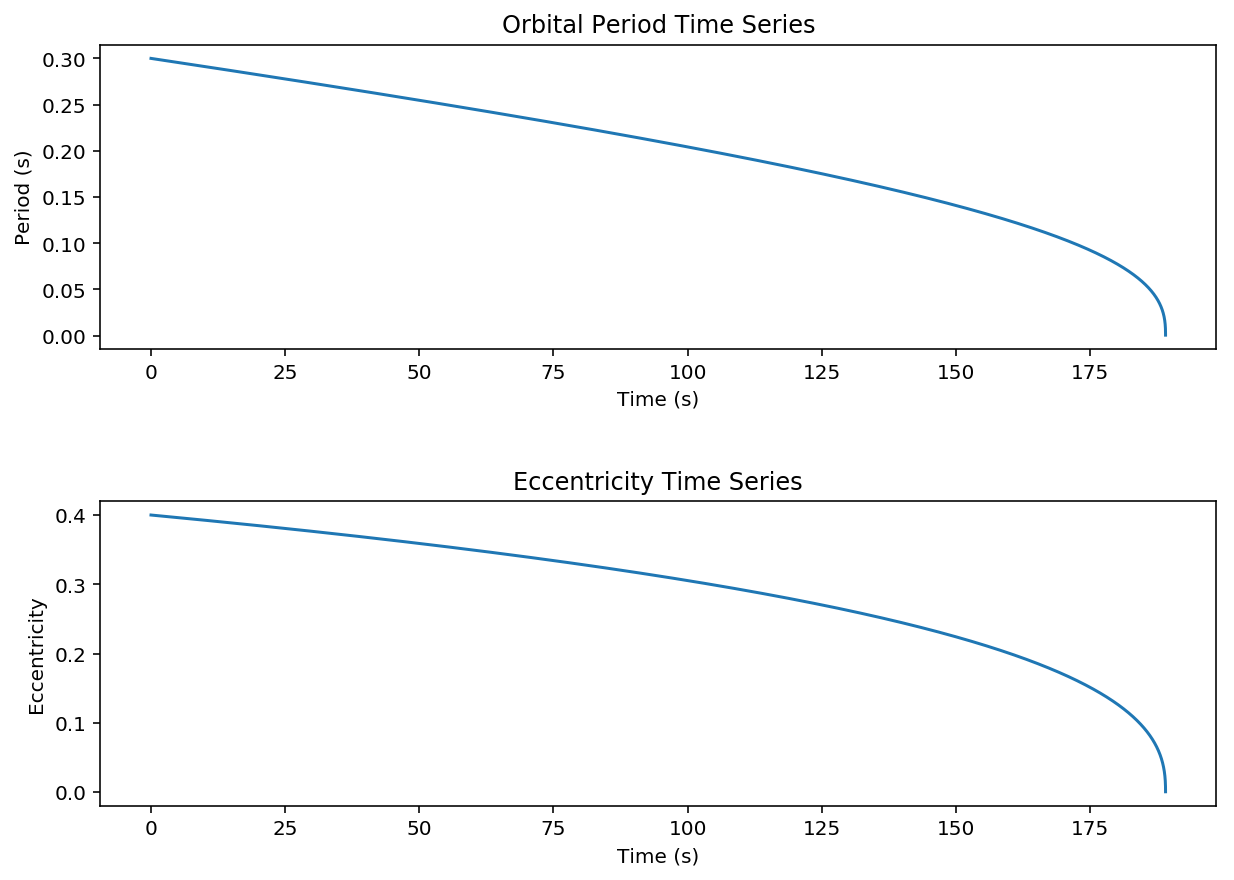

In [8]:
# Plotting: 

plt.figure(figsize=(10,7))

plt.subplot(2,1,1)
plt.plot(ts, pts)
plt.title("Orbital Period Time Series")
plt.ylabel("Period (s)")
plt.xlabel("Time (s)")

plt.subplot(2,1,2)
plt.plot(ts, ets)
plt.title("Eccentricity Time Series")
plt.xlabel("Time (s)")
plt.ylabel("Eccentricity")

plt.subplots_adjust(hspace=.5)

Blanchet derived the relationship between period and eccentricity to be: 

$$
c_0 P^{19/9} = 
\frac{e^2}{(1-e^2)^{19/6}} 
\bigg(1+\frac{121}{304}e^2\bigg)^{145/121} 
$$ 

where $c_0$ is a constant determined by the initial conditions of the binary evolution. In this case, let $P_0 = 0.1 s$ and $e_0 = 0.4$.

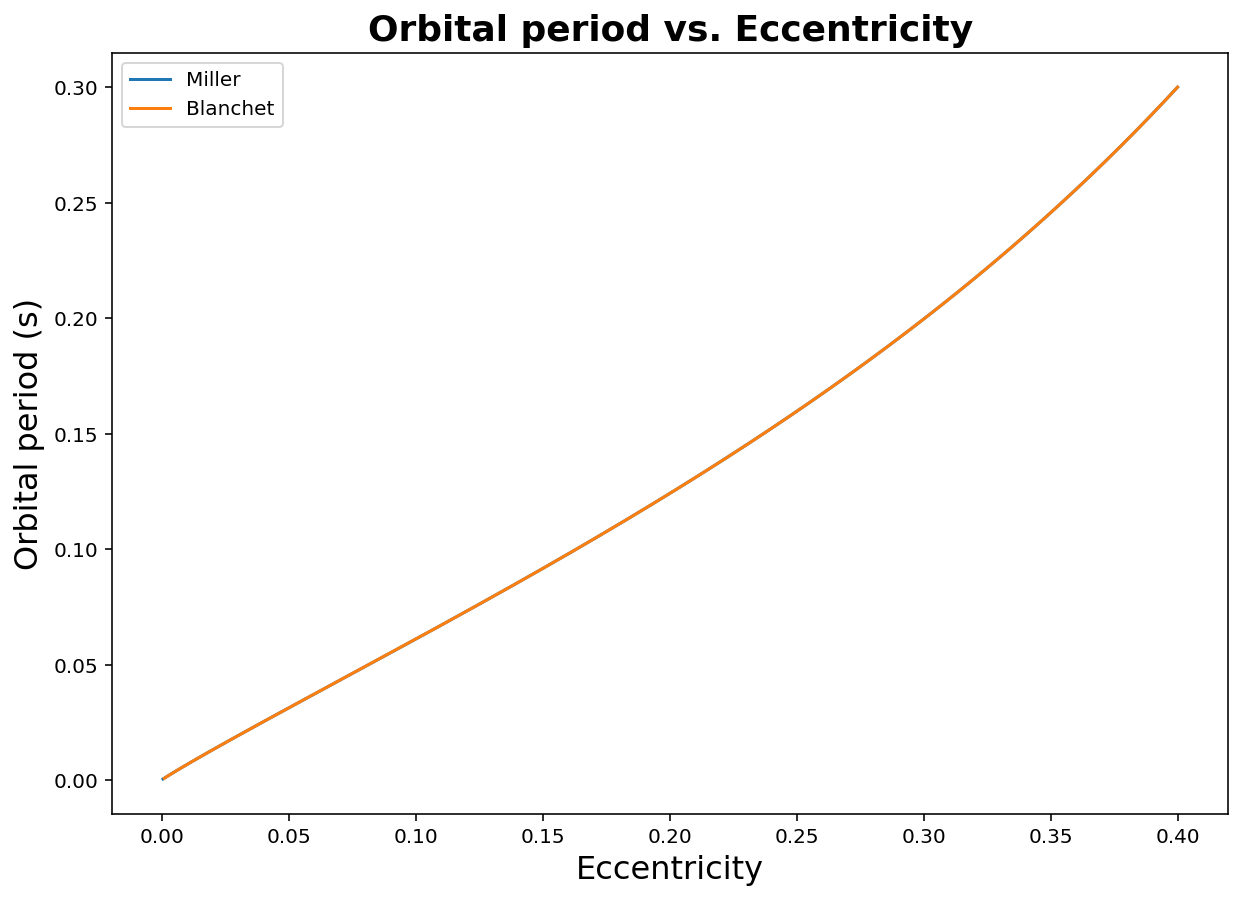

In [20]:
# Plotting orbital period vs. eccentricity

# -- From time series derived above --

plt.figure(figsize=(10,7))
plt.plot(ets, pts)
plt.title("Orbital period vs. Eccentricity",fontsize=18, fontweight="bold")
plt.xlabel("Eccentricity",fontsize=16)
plt.ylabel("Orbital period (s)",fontsize=16)


# -- From Blanchet's equation -- 

# First, find c0 for initial conditions P0 = 0.3s and e0 = 0.4

P0 = 0.3
e0 = 0.4

num0 = np.power(e0,2)*np.power(1+((121.0/304)*np.power(e0,2)), 145.0/121)
denom0 = np.power(1-np.power(e0,2), 19.0/6)*np.power(P0, 19.0/9)
c0 = num0/denom0 

# Forming equation:

ecc = np.arange(0.001, e0, 0.00001)
Per = []

for e in ecc: 
    
    num1 = np.power(e,2)*np.power(1+((121.0/304)*np.power(e,2)), 145.0/121)
    denom1 = c0*np.power(1-np.power(e,2), 19.0/6)
    P = np.power(num1/denom1, 9.0/19)
    
    Per.append(P)

plt.plot(ecc,Per)

labels = ['Miller', 'Blanchet']
plt.legend(labels)

A perfect match!

## Frequency of Emitted Gravitational Waves

$ P_{orb} = \frac{1}{f_{orb}} $ and $f_{GW} = 2 f_{orb}$

so, $P_{orb} = \frac{2}{f_{GW}}$ aka $f_{GW} = \frac{2}{P_{orb}}$

Text(0,0.5,u'Frequency of Omitted GW (Hz)')

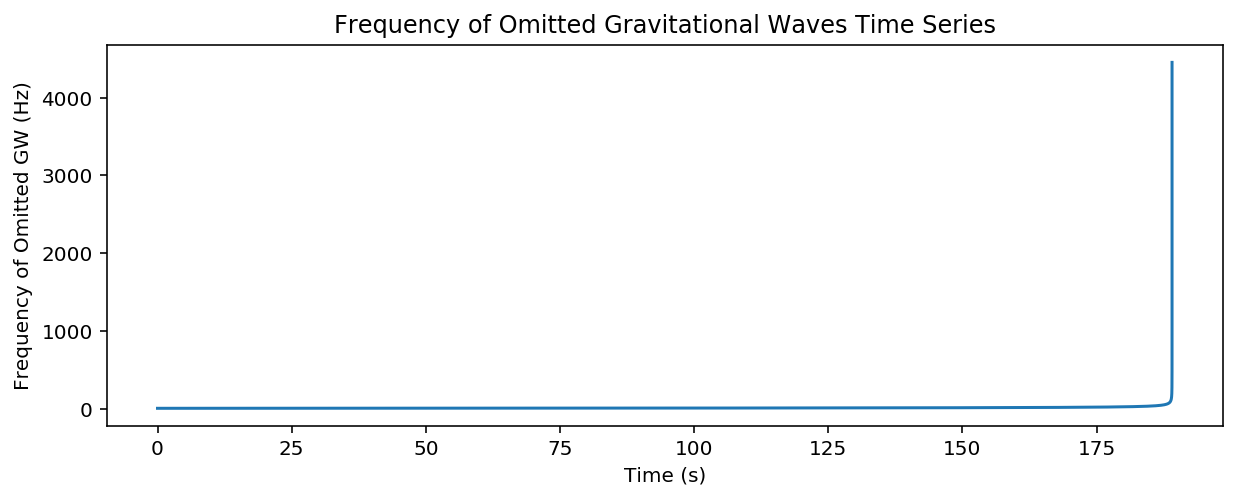

In [10]:
# Calculating frequency of emitted GW time series from above data
# f_GW = 2*f_orb = 2/P_orb

fgwts = [2.0/Per for Per in pts]

# Plotting:
plt.figure(figsize=(10,3.5))
plt.plot(ts, fgwts)
plt.title("Frequency of Omitted Gravitational Waves Time Series")
plt.xlabel("Time (s)")
plt.ylabel("Frequency of Omitted GW (Hz)")

## Orbital Separation and Semi-latus Rectum

Kepler's third law relates orbital separation and orbital period: 

$$
{P_{orb}}^2 =
a^3 
\bigg(\frac{4\pi^2}{G (m_1+m_2)}\bigg)
$$

Also written: 

$$
a^3 =
{P_{orb}}^2 
\bigg(\frac{G (m_1+m_2)}{4\pi^2}\bigg)
$$

meaning for a given orbital period $P_{orb}$, the orbital separation $a$ is: 

$$
a =
\bigg[
{P_{orb}}^2 
\bigg(\frac{G (m_1+m_2)}{4\pi^2}\bigg)
\bigg]^{1/3}
$$

Semilatus rectum, $p$ is given by the formula: 

$$
p\,=\,a\,\big(1\,-\,e^2\,\big)
$$

In [11]:
# Function to calculate orbital separation (in km) at a given orbital period
# using Keplers laws

# P = Period in s, m1 and m2 = masses in solar mass units 

def OrbitalSeparation(P,m1,m2):
    
    m1_SI = m1*Msun
    m2_SI = m2*Msun
    
    # in meters
    a3 = (P**2)*G*(m1_SI + m2_SI)/(4*(pi**2))
    a = a3**(1.0/3)
    
    # m -> km
    a = a/1000
    
    return a

Initial orbital separation: 1446.34089302 km
ISCO orbital separation: 18.9249600736 km


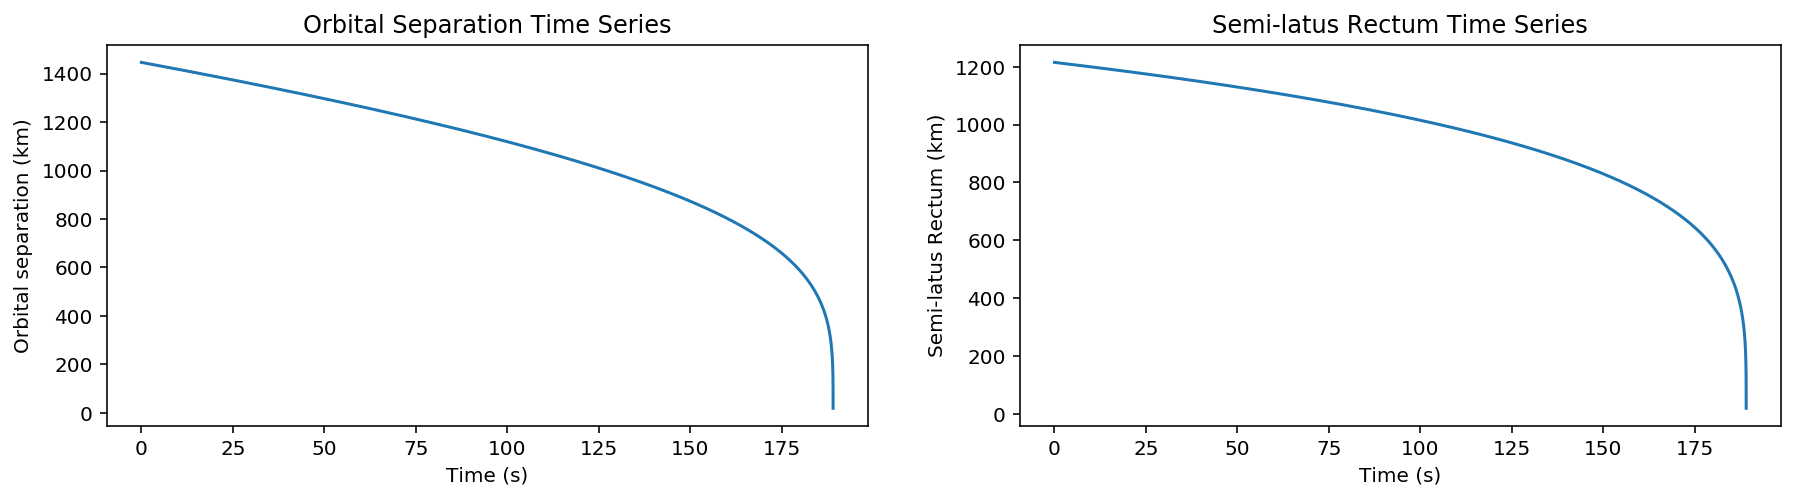

In [12]:
# Making and plotting orbital separation time series and semilatus rectum timeseries:

# Orbital sep time series
aorbts = [OrbitalSeparation(Per,m1,m2) for Per in pts]

# Semilatus rectum time series
slrts = []
for i in range(0,len(ts)):
    slr = aorbts[i]*(1-(ets[i])**2)
    slrts.append(slr)

# Plotting
plt.figure(figsize=(15,3.5))

plt.subplot(1,2,1)
plt.plot(ts, aorbts)
plt.title("Orbital Separation Time Series")
plt.xlabel("Time (s)")
plt.ylabel("Orbital separation (km)")

plt.subplot(1,2,2)
plt.plot(ts, slrts)
plt.title("Semi-latus Rectum Time Series")
plt.xlabel("Time (s)")
plt.ylabel("Semi-latus Rectum (km)")

print "Initial orbital separation:", aorbts[0], "km"
print "ISCO orbital separation:", aorbts[-1], "km"

Text(0,0.5,u'Eccentricity')

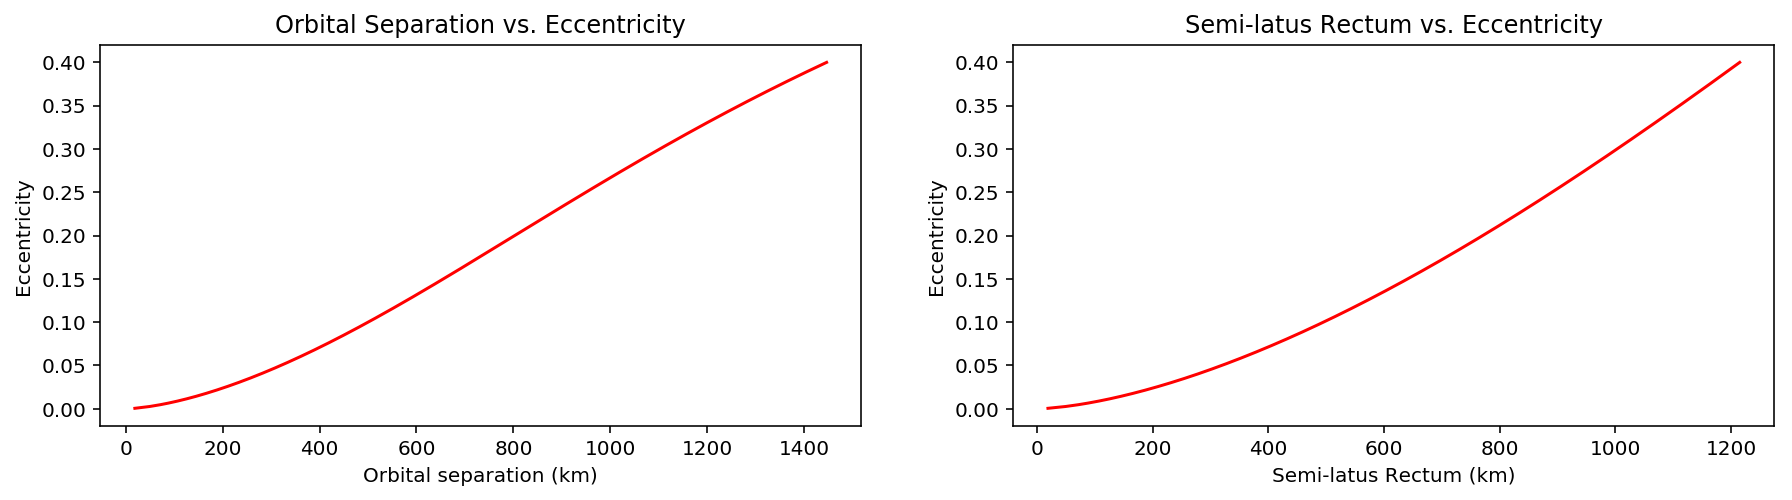

In [13]:
# Plotting a_orb and p vs e

plt.figure(figsize=(15,3.5))

plt.subplot(1,2,1)
plt.plot(aorbts, ets,'r')
plt.title("Orbital Separation vs. Eccentricity")
plt.xlabel("Orbital separation (km)")
plt.ylabel("Eccentricity")

plt.subplot(1,2,2)
plt.plot(slrts, ets, 'r')
plt.title("Semi-latus Rectum vs. Eccentricity")
plt.xlabel("Semi-latus Rectum (km)")
plt.ylabel("Eccentricity")

## Strain

Optimal strain amplitude of a gravitational wave is: 

$$
h_{amp} = 
\bigg(\frac{2 G (m_1+m_2)}{c^2 d}\bigg)
\bigg(\frac{2 G (m_1+m_2)}{c^2 a}\bigg)
$$

where $d$ is distance to the source and $a$ is the orbital separation of the BH. 

In [14]:
# Function to calculate strain amplitude at a given orbital separation and 
# distance, using equations above

# a = orbital separation in km, m1 and m2 = masses in solar mass units, 
# dist = distance from source in km

def StrainAmplitude(a,m1,m2,dist):
    
    m1_SI = m1*Msun
    m2_SI = m2*Msun
    
    # km -> m
    dist_m = 1000*dist
    a_m = 1000*a
    
    const = 2*G*(m1_SI+m2_SI)/(c**2)
    term1 = (1/dist_m)
    term2 = (1/a_m)
    
    Amp = (const*term1)*(const*term2)
    
    return Amp

In [15]:
# Set distance to one megaparsec aka 3.086e19 km: 
dist = 3.086e19  # km

# Initialize strain amplitude time series
Ampts = []

# Calculating strain amplitude time series
for a in aorbts: 
    Amp = StrainAmplitude(a,m1,m2,dist)
    Ampts.append(Amp)

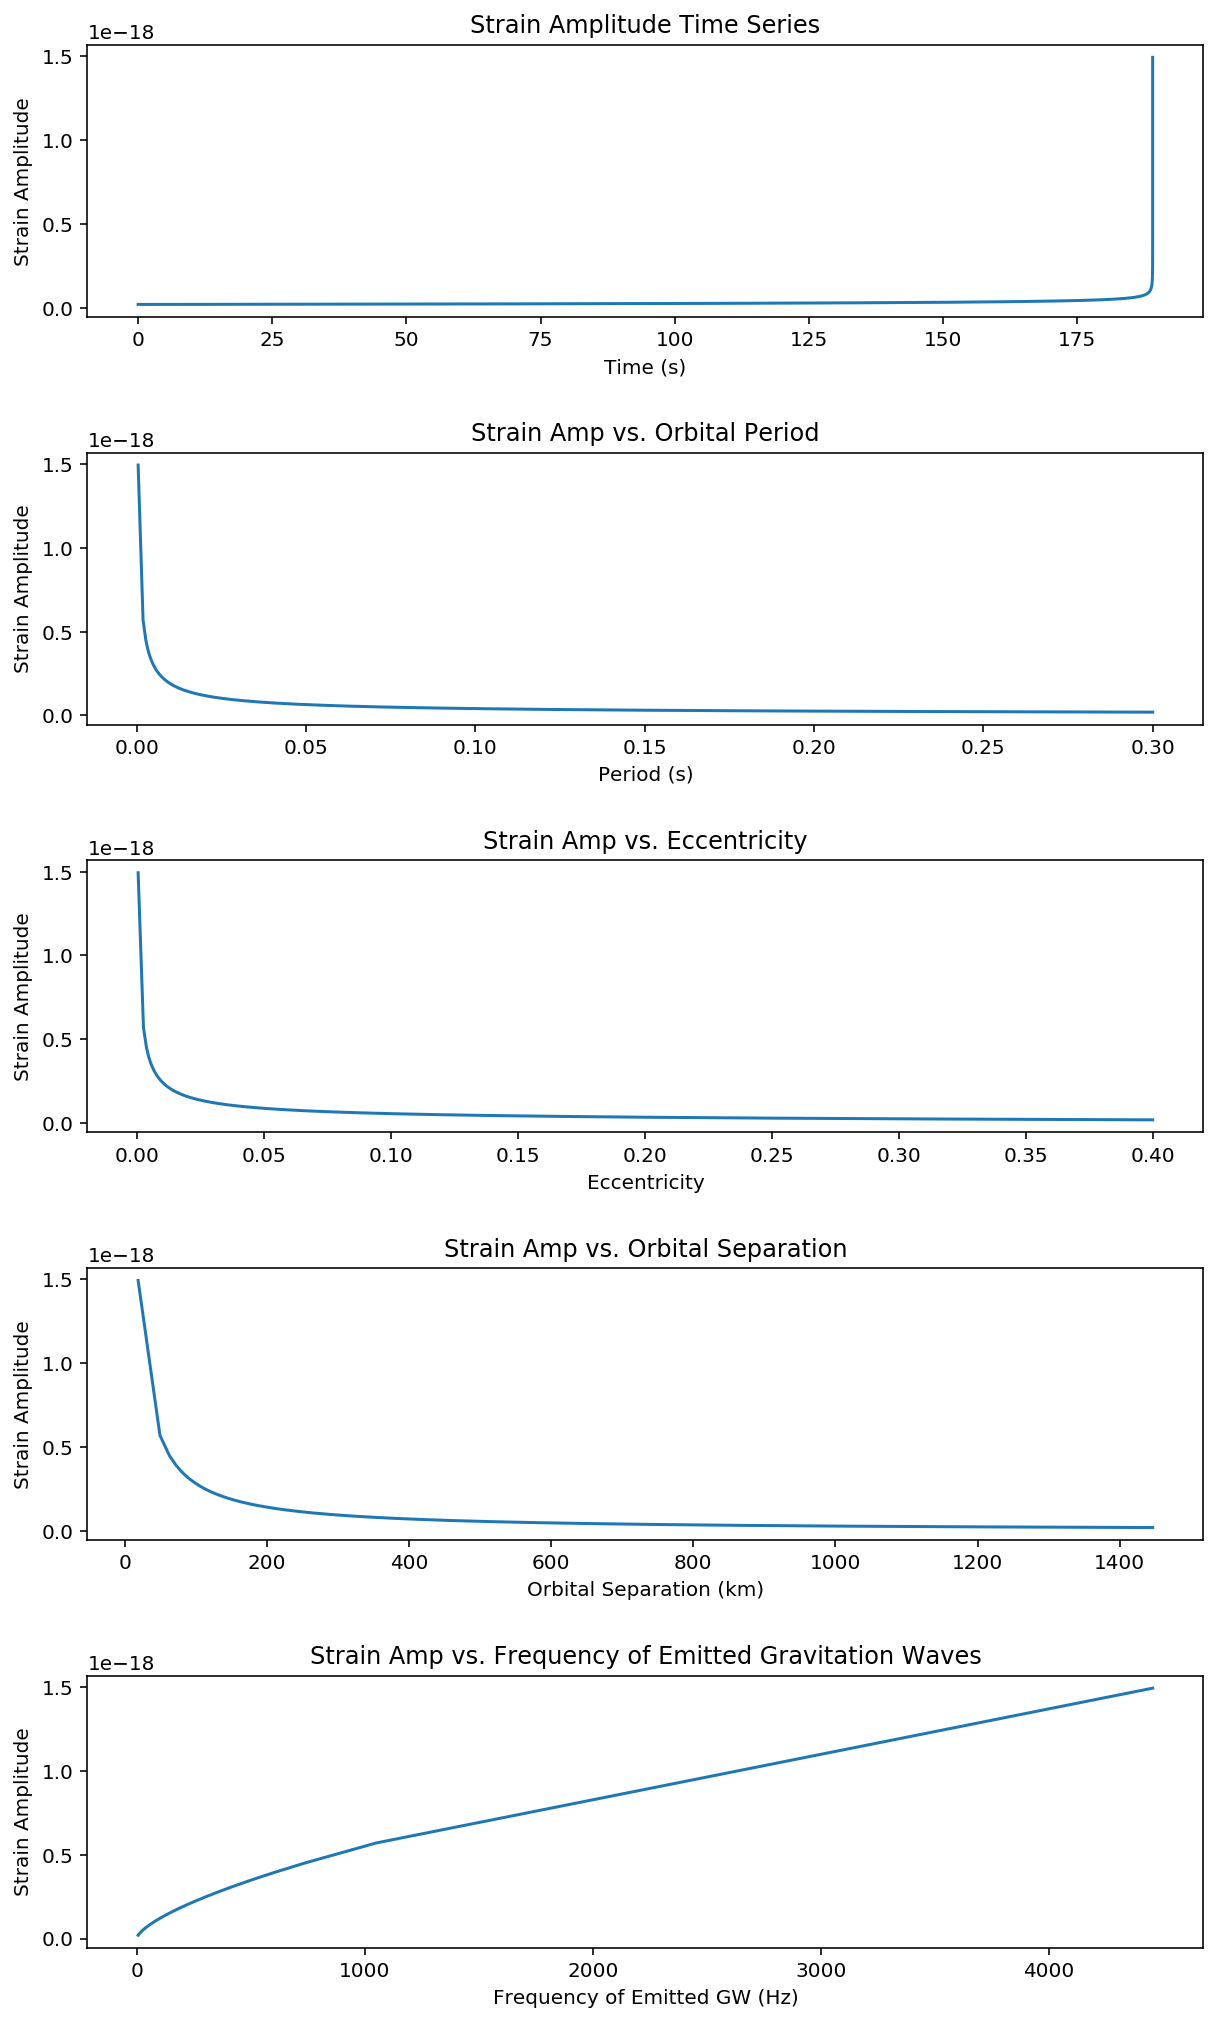

In [16]:
# Plotting strain amplitude data:

plt.figure(figsize=(10,17.5))

plt.subplot(5,1,1)
plt.plot(ts, Ampts)
plt.title("Strain Amplitude Time Series")
plt.xlabel("Time (s)")
plt.ylabel("Strain Amplitude")

plt.subplot(5,1,2)
plt.plot(pts, Ampts)
plt.title("Strain Amp vs. Orbital Period")
plt.xlabel("Period (s)")
plt.ylabel("Strain Amplitude")

plt.subplot(5,1,3)
plt.plot(ets, Ampts)
plt.title("Strain Amp vs. Eccentricity")
plt.xlabel("Eccentricity")
plt.ylabel("Strain Amplitude")

plt.subplot(5,1,4)
plt.plot(aorbts, Ampts)
plt.title("Strain Amp vs. Orbital Separation")
plt.xlabel("Orbital Separation (km)")
plt.ylabel("Strain Amplitude")


plt.subplot(5,1,5)
plt.plot(fgwts, Ampts)
plt.title("Strain Amp vs. Frequency of Emitted Gravitation Waves")
plt.xlabel("Frequency of Emitted GW (Hz)")
plt.ylabel("Strain Amplitude")

plt.subplots_adjust(hspace=.5)

In [17]:
# Creating waveform aka GW strain: strain amplitude * cosine(phase evolution) 

hts = []

# Initial phase 

for i in range(0, len(ts)):
    
    A = Ampts[i]
    f = fgwts[i]
    t = ts[i]
    
    phase = 2*pi*f*t
    
    h = A*np.cos(phase)
    hts.append(h) 

Text(0,0.5,u'Strain')

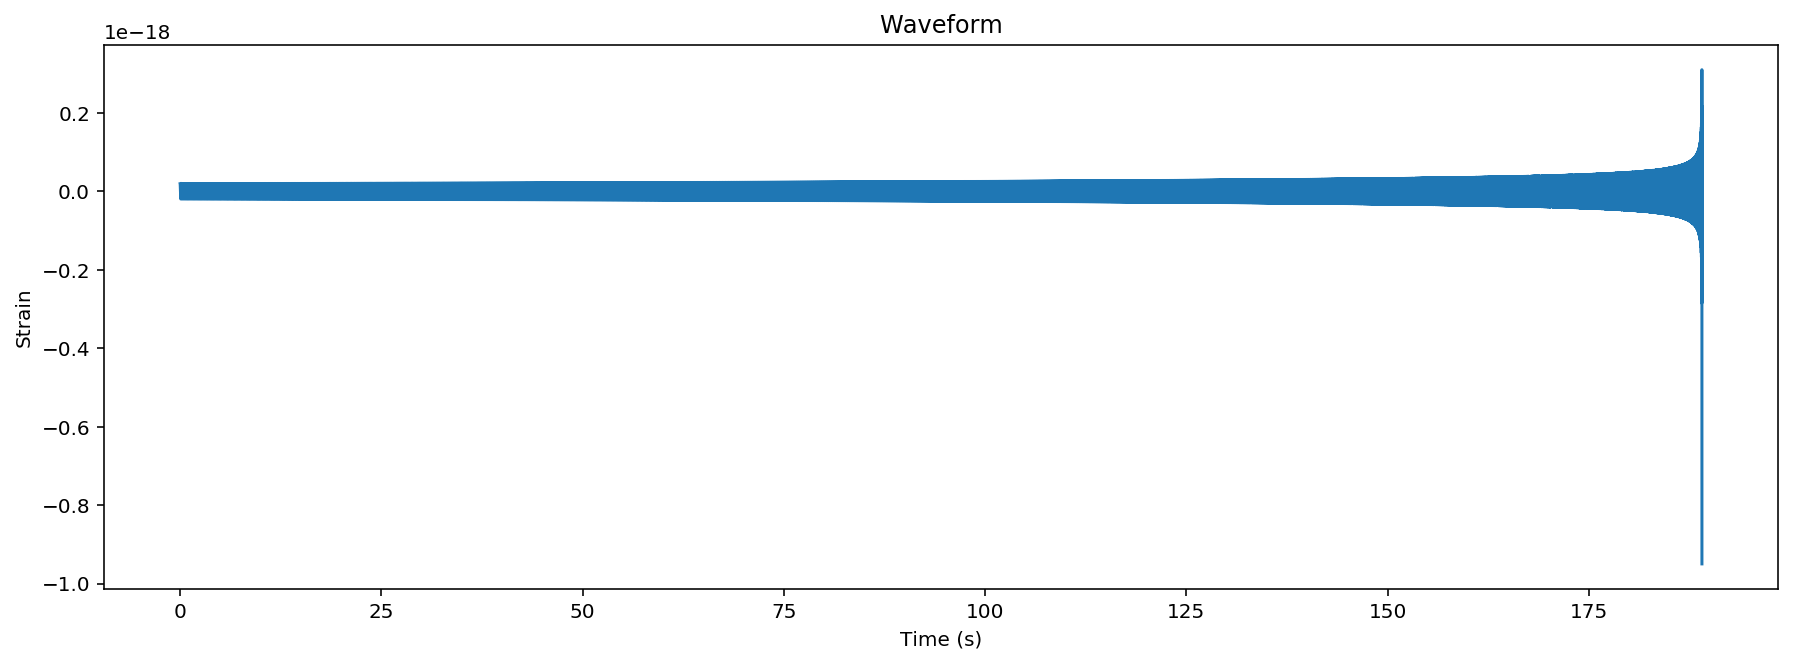

In [18]:
# Plotting waveform:
plt.figure(figsize=(15,5))
plt.plot(ts, hts)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Strain")

(2.8, 189.06010000053868)

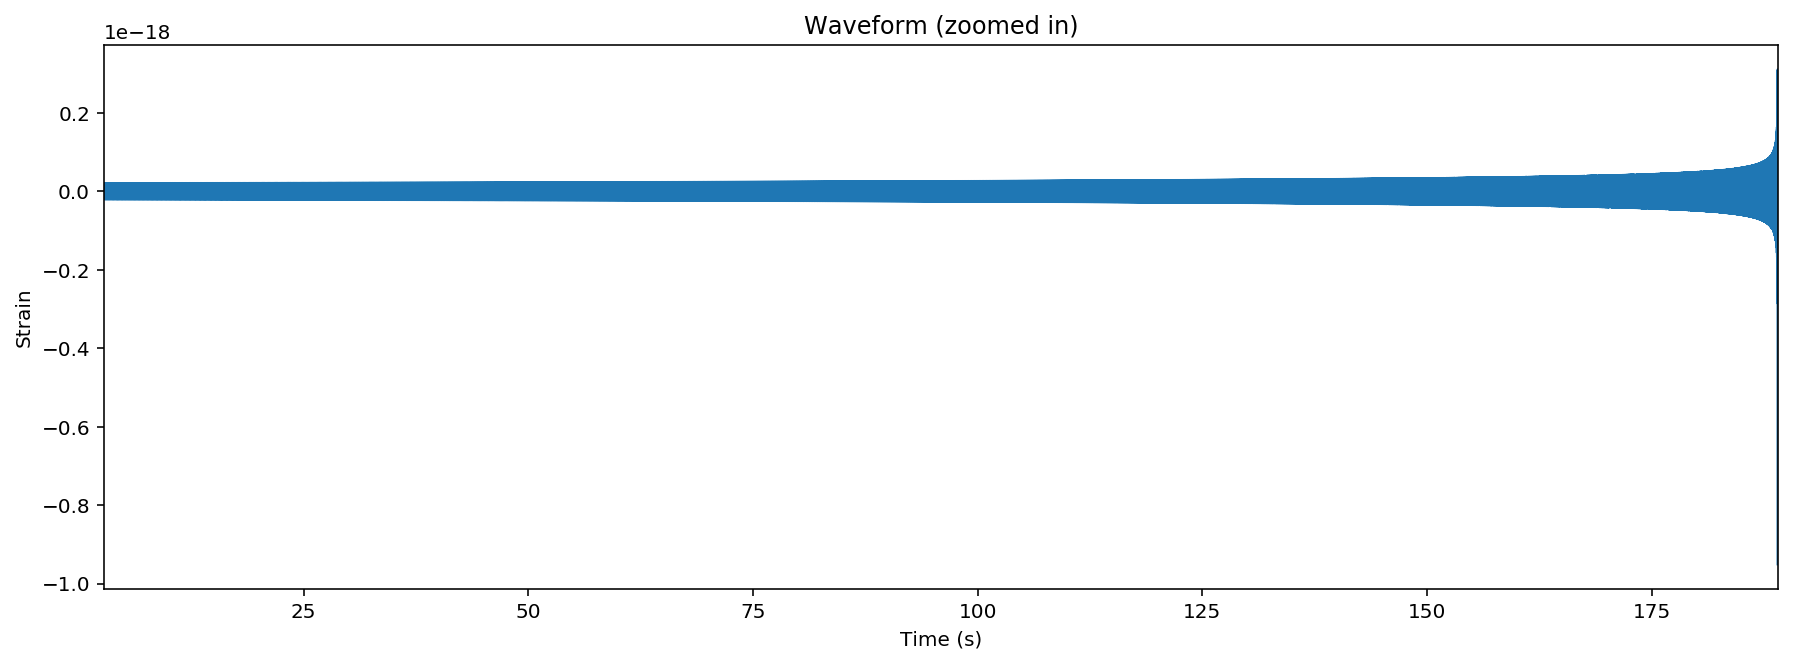

In [19]:
# Zooming in: 
plt.figure(figsize=(15,5))
plt.plot(ts,hts)
plt.title("Waveform (zoomed in)")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.xlim(2.80,ts[-1]+.0001)